In [1]:
%matplotlib inline

## Imports

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import transforms, models
from torchvision.datasets import ImageFolder

import os
import sys
import time
import copy
import datetime
import numpy as np
import pandas as pd


import imgaug as ia
import matplotlib.pyplot as plt

from imgaug import augmenters as iaa
from PIL import Image
from tqdm import tqdm_notebook as tqdm


sys.path.append('../src')
#from densenet import densenet_cifar

In [16]:
plt.style.use('seaborn-darkgrid')

## Loading and preparing data

#### Paths to data

In [17]:
data_dir = 'C:/PW/MGU/P2/data'

In [34]:
classes = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9, 
}

#### Transformations 

In [18]:
class CustomTransform:
    def __init__(self):
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        self.seq = iaa.Sequential(
            [
                iaa.Resize(size=(36, 36)),
                iaa.CropToFixedSize(height=32, width=32),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.2),
                sometimes(iaa.Affine(rotate=(-20, 20))),
                iaa.SomeOf((0, 5),
                    [
                        sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                        iaa.OneOf([
                            iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                            iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                            iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                        ]),
                        iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                        iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                        # search either for all edges or for directed edges,
                        # blend the result with the original image using a blobby mask
                        iaa.SimplexNoiseAlpha(iaa.OneOf([
                            iaa.EdgeDetect(alpha=(0.5, 1.0)),
                            iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                        ])),
                        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5), # add gaussian noise to images
                        iaa.OneOf([
                            iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
                            iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                        ]),
                        iaa.Invert(0.05, per_channel=True), # invert color channels
                        iaa.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                        iaa.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                        # either change the brightness of the whole image (sometimes
                        # per channel) or change the brightness of subareas
                        iaa.OneOf([
                            iaa.Multiply((0.5, 1.5), per_channel=0.5),
                            iaa.FrequencyNoiseAlpha(
                                exponent=(-4, 0),
                                first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                second=iaa.ContrastNormalization((0.5, 2.0))
                            )
                        ]),
                        iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5), # improve or worsen the contrast
                        iaa.Grayscale(alpha=(0.0, 1.0)),
                        sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)), # move pixels locally around (with random strengths)
                        sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))), # sometimes move parts of the image around
                        sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                    ],
                    random_order=True
                )
            ]              
        )
        
    def __call__(self, pic):
        pic = np.array(pic)
        return np.copy(self.seq.augment_image(pic))

In [19]:
train_transform = transforms.Compose([
    transforms.Resize((36, 36)),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.247, 0.243, 0.261)),
])

#### DataLoaders

In [20]:
train_provider = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_provider, batch_size=128, shuffle=True, num_workers=4)

valid_provider = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=test_transform)
valid_loader = DataLoader(valid_provider, batch_size=128, shuffle=False, num_workers=4)

dataloaders = {
    'train': train_loader,
    'valid': valid_loader,
}

Files already downloaded and verified
Files already downloaded and verified


### Visualise some photos

In [21]:
def visualise_data(provider, examples_per_cat=10):
    fig, axes = plt.subplots(nrows=len(provider.classes), ncols=examples_per_cat, figsize=(10, 10))
    for name, idx in provider.class_to_idx.items():
        labels_idx = np.random.choice(np.argwhere(np.array(provider.targets) == idx).flatten(), examples_per_cat, replace=False)
        examples = provider.data[labels_idx, ...]
        for i, img in enumerate(examples):
            axes[idx, i].imshow(img, aspect='auto')
            axes[idx, i].get_xaxis().set_ticks([])
            axes[idx, i].get_yaxis().set_ticks([])
            if i == 0:
                axes[idx, i].set_ylabel(name)
    plt.yticks(range(10), range(10))
    plt.show()

#### Train images

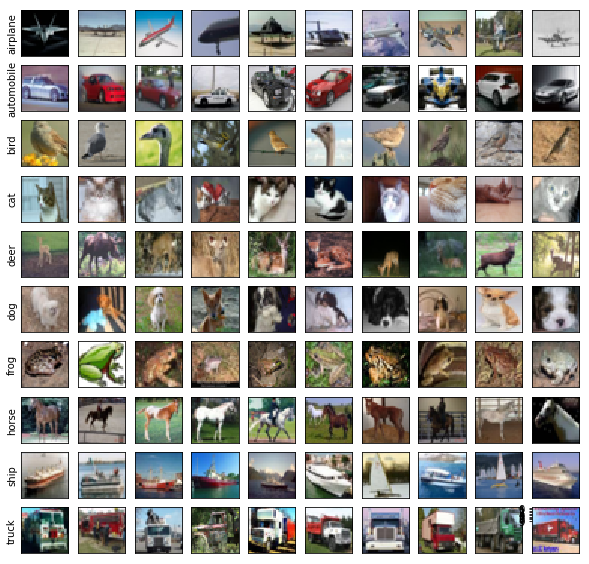

In [7]:
visualise_data(train_provider)

#### Validation images

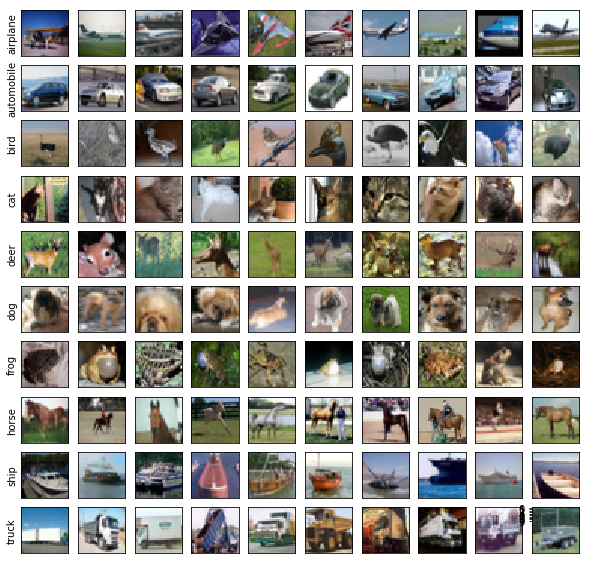

In [8]:
visualise_data(valid_provider)

## Tool for training visualisation

In [22]:
class Summary:
    def __init__(self, model_class):
        self._model_class = model_class
        self._epochs = {
            'train': [],
            'valid': []
        }
        self._losses = {
            'train': [],
            'valid': []
        }
        self._accuracies = {
            'train': [],
            'valid': []
        }
        
        self._best = {
            'accuracy': 0,
            'weights': None
        }
        
        self._lr = []
        
        self._start = 0
        self._durations = [0]
        
    def start(self):
        self._start = time.time()
    
    def stop(self):
        if self._start == 0:
            raise RuntimeException('Executing Summary.stop() without Summary.start()')
        self._durations.append(time.time() - self._start)
        self._start = 0
    
    def set_best(self, accuracy, weights):
        self._best['accuracy'] = accuracy
        self._best['weights'] = weights
    
    @property
    def duration(self):
        return sum(self._durations)
    
    @property
    def best_accuracy(self):
        return self._best['accuracy']
        
    def add(self, epoch, loss, accuracy, lr=None, phase='train'):
        assert phase in ['train', 'valid']
        self._epochs[phase].append(epoch)
        self._losses[phase].append(loss)
        self._accuracies[phase].append(accuracy)
        if not lr is None:
            self._lr.append(lr)
        
    def plot_loss(self, figsize):
        fig = plt.figure(figsize=figsize)
        plt.plot(self._epochs['train'], self._losses['train'], label='Train')
        plt.plot(self._epochs['valid'], self._losses['valid'], label='Valid')
        plt.title('Loss Plot')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def plot_accuracy(self, figsize):
        fig = plt.figure(figsize=figsize)
        plt.plot(self._epochs['train'], self._accuracies['train'], label='Train')
        plt.plot(self._epochs['valid'], self._accuracies['valid'], label='Valid')
        plt.title('Accuracy Plot')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy [%]')
        plt.legend()
        plt.show()
        
    def plot_lr(self, figsize):
        fig = plt.figure(figsize=figsize)
        plt.plot(self._epochs['train'], self._lr)
        plt.title('Learning Rate')
        plt.xlabel('Epochs')
        plt.ylabel('Value')
        plt.show()
        
    def summarise(self):
        print(f'Training complete in {str(datetime.timedelta(seconds=self.duration))}')
        print(f'Total training epochs: {self._epochs["train"][-1]}')
        print(f'Best validation accuracy: {self._best["accuracy"]:.4f}')

## Neural Network
#### Device selection {GPU/CPU}

In [23]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### Architecture

In [36]:
model = models.resnet50(pretrained=False)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_provider.classes))

#model = densenet_cifar()
model = model.to(device)

#### Other training stuff

In [29]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

# scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=300, eta_min=0.0001)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[90, 150] , gamma=0.1)

## Training

In [31]:
def train(model, data_loader, criterion, optimizer, scheduler):
        model.train()
        scheduler.step()
        train_loss, corrects = 0, 0
        for data, y_true in data_loader:
            data = data.to(device)
            y_true = y_true.to(device)

            optimizer.zero_grad()
            y_pred = model(data)

            loss = criterion(y_pred, y_true)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * data.size(0)
            corrects += torch.sum(torch.argmax(y_pred, dim=1) == y_true).item()
        train_loss /= len(data_loader.dataset)
        train_acc = corrects / len(data_loader.dataset) * 100
        return train_acc, train_loss
    
    
def validate(model, data_loader, criterion):    
    model.eval()
    valid_loss, corrects = 0, 0
    with torch.no_grad():
        for data, y_true in data_loader:
            data = data.to(device)
            y_true = y_true.to(device)

            y_pred = model(data)

            loss = criterion(y_pred, y_true)

            valid_loss += loss.item() * data.size(0)
            corrects += torch.sum(torch.argmax(y_pred, dim=1) == y_true).item()
    valid_loss /= len(data_loader.dataset)
    valid_acc = corrects / len(data_loader.dataset) * 100
    return valid_acc, valid_loss
    
    
def fit(model, dataloaders, criterion, optimizer, scheduler, epochs, test_epochs, start_epoch=0, summary=None):
    if summary is None:
        summary = Summary(model.__class__.__name__)
        summary.set_best(accuracy=0, weights=copy.deepcopy(model.state_dict()))
    best_acc = summary.best_accuracy
    
    if epochs < start_epoch:
        epochs = epochs + start_epoch
        
    summary.start()
    try:
        for epoch in tqdm(range(start_epoch, epochs)):
            train_epoch_acc, train_epoch_loss = train(model, dataloaders['train'], criterion, optimizer, scheduler)
            lr = optimizer.param_groups[0]['lr']
            summary.add(epoch, train_epoch_loss, train_epoch_acc, lr, phase='train')
            if epoch % test_epochs == 0 or epoch == epochs-1:
                valid_epoch_acc, valid_epoch_loss = validate(model, dataloaders['valid'], criterion)
                summary.add(epoch, valid_epoch_loss, valid_epoch_acc, phase='valid')
                print(f'Epoch: {epoch}, Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.2f}%,\
                        Valid Loss: {valid_epoch_loss:.4f}, Valid Acc: {valid_epoch_acc:.2f}%')
                
                if valid_epoch_acc > best_acc:
                    best_acc = valid_epoch_acc
                    best_weights = copy.deepcopy(model.state_dict())
                    summary.set_best(best_acc, best_weights)
                
    except KeyboardInterrupt:
        pass
    
    summary.stop()
    return summary

In [32]:
summary = fit(model, dataloaders, criterion, optimizer, scheduler, epochs=200, test_epochs=10)

Exception ignored in: <function tqdm.__del__ at 0x000001C8343E3158>
Traceback (most recent call last):
  File "C:\Users\radzi\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 931, in __del__
    self.close()
  File "C:\Users\radzi\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 1133, in close
    self._decr_instances(self)
  File "C:\Users\radzi\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 496, in _decr_instances
    cls.monitor.exit()
  File "C:\Users\radzi\Anaconda3\lib\site-packages\tqdm\_monitor.py", line 52, in exit
    self.join()
  File "C:\Users\radzi\Anaconda3\lib\threading.py", line 1029, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread


In [ ]:
summary.summarise()

In [ ]:
summary._durations

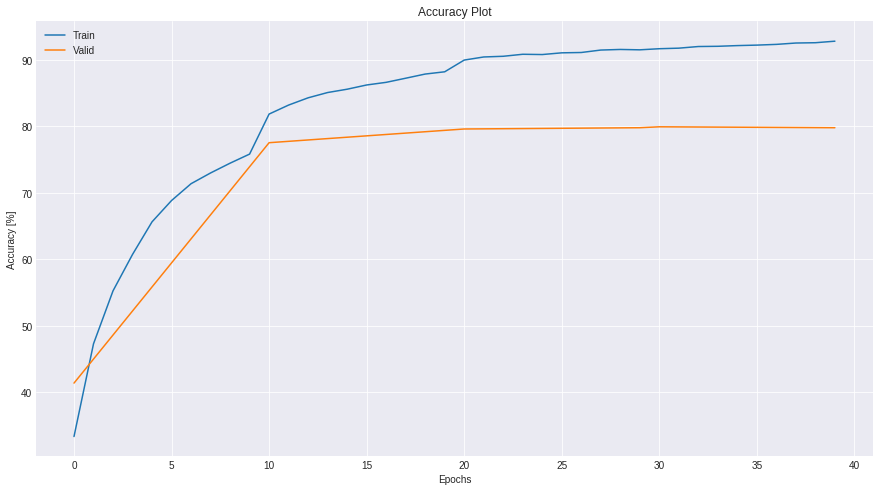

In [76]:
summary.plot_accuracy(figsize=(15,8))

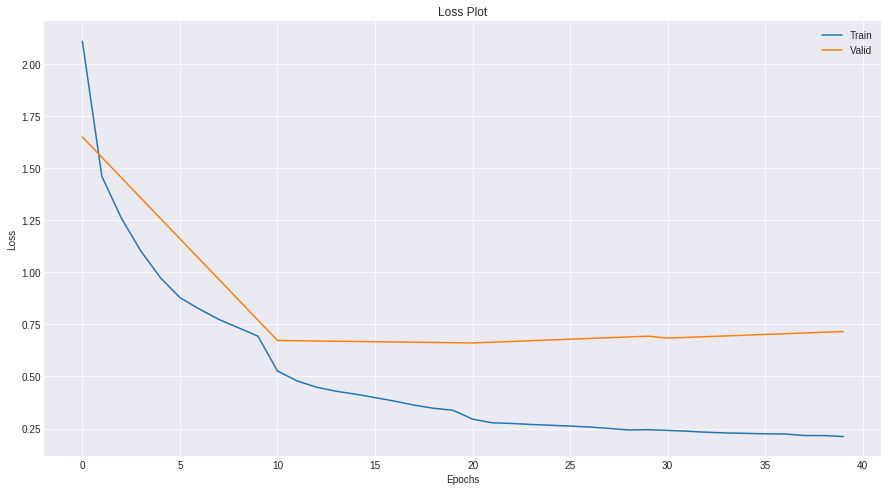

In [77]:
summary.plot_loss(figsize=(15,8))

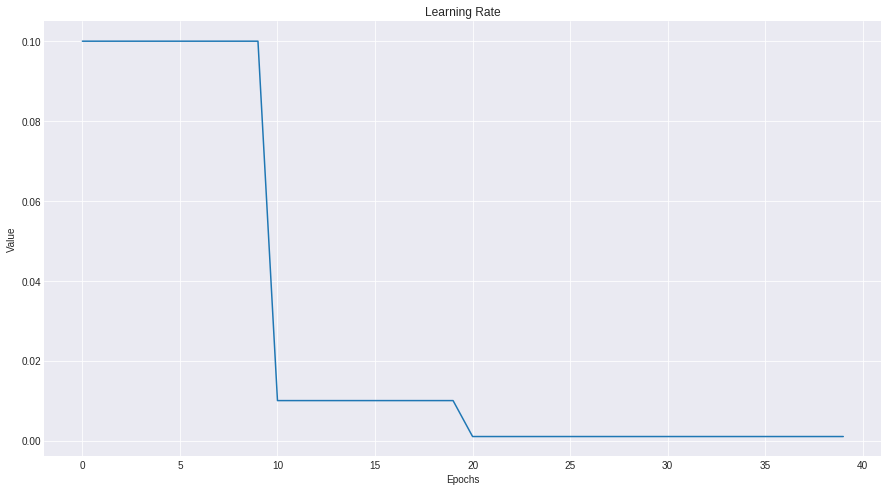

In [78]:
summary.plot_lr(figsize=(15,8))

In [58]:
def save_progress(path, model, summary, optimizer, scheduler):
    save_dict = {
        'model': model.state_dict(),
        'summary': summary,
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
    }
    torch.save(save_dict, path)
    
def load_progress(path, model, summary, optimizer, scheduler):
    progress_dict = torch.load(path)
    model.load_state_dict(progress_dict['model'])
    optimizer.load_state_dict(progress_dict['optimizer'])
    scheduler.load_state_dict(progress_dict['scheduler'])
    summary = progress_dict['summary']
    return summary

In [59]:
save_progress('../models/test', model, summary, optimizer, scheduler)

In [71]:
# summary = load_progress('../models/test', model, summary, optimizer, scheduler)

In [72]:
# validate(model, dataloaders['valid'], criterion)

(79.79, 0.6933395434856415)

In [73]:
# summary = fit(model, dataloaders, criterion, optimizer, scheduler, epochs=40, test_epochs=10, start_epoch=30, summary=summary)

Epoch: 30, Train Loss: 0.2414, Train Acc: 91.66%,                        Valid Loss: 0.6842, Valid Acc: 79.93%
Epoch: 39, Train Loss: 0.2120, Train Acc: 92.80%,                        Valid Loss: 0.7157, Valid Acc: 79.79%

